<H2> Preparing the data first... </h2>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import os
from keras import regularizers
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback, EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# roc curve and auc score
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

trainData = pd.read_csv("../input/widsdatathon2020/training_v2.csv")
testData = pd.read_csv("../input/widsdatathon2020/unlabeled.csv")

# Any results you write to the current directory are saved as output.

/kaggle/input/widsdatathon2020/unlabeled.csv
/kaggle/input/widsdatathon2020/training_v2.csv
/kaggle/input/widsdatathon2020/solution_template.csv
/kaggle/input/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv
/kaggle/input/widsdatathon2020/samplesubmission.csv


In [3]:
categorical_cols = [c for c in trainData.columns if (trainData[c].dtype != np.number)& (trainData[c].dtype != int) ]
Categorical_df= trainData[categorical_cols]
# for col in categorical_cols:
#     print(col, "*****************")
#     print(Categorical_df[col].value_counts(), Categorical_df[col].unique())

In [4]:
# frequency encoder
for col in ['ethnicity', 'hospital_admit_source', 'icu_admit_source', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_type']:
    trainData[col] = trainData[col].astype('str')
    freq = trainData.groupby(col).size()/len(trainData[col])
    trainData[col] = trainData[col].map(freq)
    
    testData[col] = testData[col].astype('str')
    freq = testData.groupby(col).size()/len(testData[col])
    testData[col] = testData[col].map(freq)

trainData.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,0.770709,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.128008,0.423233
1,114252,59342,81,0,77.0,27.42,0,0.770709,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.126580,0.126580
2,119783,50777,118,0,25.0,31.95,0,0.770709,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083412,0.083412
3,79267,46918,118,0,81.0,22.64,1,0.770709,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327096,0.423233
4,92056,34377,33,0,19.0,NaN,0,0.770709,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041892,0.041892


In [5]:
# ordinal encoder
icu_st_dict={'admit':0,'readmit':1,'transfer':2}

trainData['icu_stay_type'] = trainData['icu_stay_type'].astype('str')
trainData['icu_stay_type'] = trainData['icu_stay_type'].map(icu_st_dict)

testData['icu_stay_type'] = testData['icu_stay_type'].astype('str')
testData['icu_stay_type'] = testData['icu_stay_type'].map(icu_st_dict)

In [6]:
trainData['icu_stay_type'].tail(10)
trainData['icu_type'].tail(10)

91703    0.551568
91704    0.052075
91705    0.551568
91706    0.551568
91707    0.551568
91708    0.052075
91709    0.551568
91710    0.551568
91711    0.551568
91712    0.551568
Name: icu_type, dtype: float64

In [7]:
# label encoding the data gender
le = LabelEncoder()
for col in ['gender']:
    trainData[col] = trainData[col].astype('str')

    #Fit LabelEncoder
    le.fit(np.unique(trainData[col].unique()))

    #At the end 0 will be used for null values so we start at 1 
    trainData[col] = le.transform(trainData[col])+1
    trainData[col] = trainData[col].replace(np.nan, 0).astype('int')
    
    testData[col] = testData[col].astype('str')

    #Fit LabelEncoder
    le.fit(np.unique(testData[col].unique()))

    #At the end 0 will be used for null values so we start at 1 
    testData[col] = le.transform(testData[col])+1
    testData[col] = testData[col].replace(np.nan, 0).astype('int')

testData.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,0.769309,2,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152361,0.152361
1,5,130737,178,NaN,NaN,19.500595,1,0.769309,1,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152361,0.152361
2,7,101458,86,NaN,66.0,32.518596,1,0.113743,2,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289839,0.377251
3,8,48067,163,NaN,64.0,20.798520,0,0.769309,2,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.134426,0.134426
4,10,25865,59,NaN,56.0,NaN,0,0.769309,2,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152361,0.152361


In [8]:
# replace na with mean for following categories

for col in ['age', 'bmi', 'weight', 'height']:
    mean = trainData[col].mean()
    trainData[col] = trainData[col].replace(np.nan, mean).astype('int')
    
    mean = testData[col].mean()
    testData[col] = testData[col].replace(np.nan, mean).astype('int')

In [9]:
x = testData.isnull().sum(axis=0)
x

encounter_id                       0
patient_id                         0
hospital_id                        0
hospital_death                 39308
age                                0
                               ...  
leukemia                         179
lymphoma                         179
solid_tumor_with_metastasis      179
apache_3j_bodysystem               0
apache_2_bodysystem                0
Length: 186, dtype: int64

In [10]:
trainData = trainData.replace(np.nan, 0).astype('int')
testData = testData.replace(np.nan, 0).astype('int')
testData.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,0,56,21,0,0,2,180,...,0,0,0,0,0,0,0,0,0,0
1,5,130737,178,0,61,19,1,0,1,145,...,0,0,0,0,0,0,0,0,0,0
2,7,101458,86,0,66,32,1,0,2,170,...,0,0,0,0,0,0,0,0,0,0
3,8,48067,163,0,64,20,0,0,2,182,...,0,0,0,0,1,0,0,0,0,0
4,10,25865,59,0,56,28,0,0,2,169,...,0,0,0,0,0,0,0,0,0,0


<h2> Training the data now... </h2>

In [11]:
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death', 'hospital_id']
testDataOld = testData
trainLabel = trainData['hospital_death']
for col in to_drop:
    trainData = trainData.drop(col, axis = 1)
    testData = testData.drop(col, axis = 1)

trainData.head()

,age,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,68,22,0,180,0,0,92,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,77,27,0,160,0,0,90,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,25,31,0,172,0,0,93,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,81,22,1,165,0,0,92,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19,29,0,188,0,0,91,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cols_with_missing = (col for col in y_test.columns if y_test[col].isnull().any())
for col in cols_with_missing:
    y_test[col + '_was_missing'] = y_test[col].isnull()
    y_test[col + '_was_missing'] = y_test[col].isnull()

NameError: name 'y_test' is not defined

In [13]:
x_train, y_test ,x_label, y_label = train_test_split(trainData, trainLabel, test_size=0.3, random_state=1)
std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
y_test  = std_scale.transform(y_test)
testData = std_scale.transform(testData)
x_train.shape

(64199, 180)

In [14]:
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# from sklearn.feature_selection import SelectKBest, SelectFpr, f_classif

# reg = LinearRegression()
# x_train_new = SelectFpr(f_classif, alpha=0.01).fit_transform(x_train, x_label)
# fit = reg.fit(x_train_new, x_label)
# pred = fit.predict(y_test)
# print(testData.shape, pred.shape)

# auc = roc_auc_score(y_label, pred)
# fpr, tpr, thresholds = roc_curve(y_label, pred)
# plot_roc_curve(fpr, tpr)
# print(auc)
# pred = fit.predict(testData)
# testDataOld["hospital_death"] = pred
# testDataOld[["encounter_id","hospital_death"]].to_csv("submission.csv",index=False)
# testDataOld[["encounter_id","hospital_death"]].head()

In [15]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [16]:
checkpoint_callback = ModelCheckpoint("model.h5", monitor='accuracy', save_best_only=True, save_freq=2)
y_test.shape

(27514, 180)

In [17]:
model = Sequential()
model.add(Dense(64, input_shape=(180,),kernel_initializer='normal', activation='sigmoid', name='fc1'))
model.add(Dense(32, activation='sigmoid',kernel_initializer='normal', name='fc3'))
model.add(Dense(1, name='output'))
optimizer = tf.keras.optimizers.RMSprop(0.0001)

In [18]:
model.compile(optimizer, loss='mse', metrics=['accuracy', 'mse'])

In [19]:
model.fit(x_train, x_label, batch_size=60, epochs=50, callbacks=[checkpoint_callback])

Train on 64199 samples
Epoch 1/50
64199/64199 [==============================] - 3s 43us/sample - loss: 0.0663 - accuracy: 0.9165 - mse: 0.0663
Epoch 2/50
64199/64199 [==============================] - 2s 31us/sample - loss: 0.0617 - accuracy: 0.9215 - mse: 0.0617
Epoch 3/50
64199/64199 [==============================] - 2s 32us/sample - loss: 0.0612 - accuracy: 0.9225 - mse: 0.0612
Epoch 4/50
64199/64199 [==============================] - 2s 31us/sample - loss: 0.0609 - accuracy: 0.9232 - mse: 0.0609
Epoch 5/50
64199/64199 [==============================] - 2s 31us/sample - loss: 0.0607 - accuracy: 0.9235 - mse: 0.0607
Epoch 6/50
64199/64199 [==============================] - 2s 32us/sample - loss: 0.0606 - accuracy: 0.9234 - mse: 0.0606
Epoch 7/50
64199/64199 [==============================] - 2s 32us/sample - loss: 0.0605 - accuracy: 0.9235 - mse: 0.0605
Epoch 8/50
64199/64199 [==============================] - 2s 31us/sample - loss: 0.0604 - accuracy: 0.9238 - mse: 0.0604
Epoch 9/5

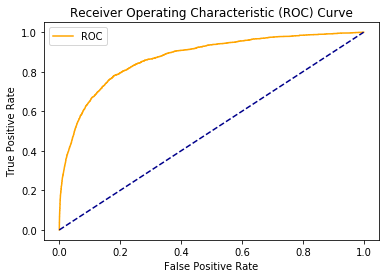

AUC-ROC : 0.8721801432424632


array([0.01159199, 0.07404302, 0.05196293, ..., 0.06427459, 0.0302742 ,
       0.05582491], dtype=float32)

In [20]:
probs = model.predict_proba(y_test).flatten()
auc = roc_auc_score(y_label, probs)
fpr, tpr, thresholds = roc_curve(y_label, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)
probs

In [21]:
probstest = model.predict_proba(testData)
probstest = probstest[:]
print(probstest)
testDataOld["hospital_death"] = probstest
testDataOld[["encounter_id","hospital_death"]].to_csv("submission3.csv",index=False)
testDataOld[["encounter_id","hospital_death"]].head()
testDataOld[["encounter_id","hospital_death"]].head()

[[ 0.05391884]
 [-0.0076026 ]
 [ 0.05280583]
 ...
 [ 0.11069826]
 [ 0.0492777 ]
 [ 0.12105015]]


,encounter_id,hospital_death
0,2,0.053919
1,5,-0.007603
2,7,0.052806
3,8,0.229574
4,10,0.164922


In [22]:
from IPython.display import FileLink
import os
os.chdir(r'/kaggle/working')
FileLink(r'submission3.csv')

/kaggle/working/submission3.csv